# Identify canidate causal genes for pQTLs

In [1]:
import pathlib
import pandas
import numpy

import hetmech.hetmat
import hetmech.pipeline

## Read pQTL associations and candidate genes

In [2]:
pqtl_df = pandas.read_table('pqtl.tsv')
loci_df = pandas.read_table('snps-to-locus-genes.tsv')
loci_df = loci_df.drop_duplicates()
snp_df = pqtl_df.merge(loci_df)
# Drop protein complexes
snp_df = snp_df.dropna(subset=['pqtl_entrez_id', 'locus_entrez_id'])
snp_df = snp_df[~snp_df.pqtl_entrez_id.str.contains(',')]
for col in 'pqtl_entrez_id', 'locus_entrez_id':
    snp_df[col] = snp_df[col].astype(int)
snp_df.head(2)

,snp,pqtl_gene,pqtl_entrez_id,neg_log10_p,gwas_source,locus_gene,locus_entrez_id,distance_to_snp
0,rs651007,SELE,6401,102.728,23300549,ABO,28,3217
1,rs651007,SELE,6401,102.728,23300549,SURF6,6838,50343


In [3]:
gene_pairs = set(zip(snp_df.pqtl_entrez_id, snp_df.locus_entrez_id))
len(gene_pairs)

111716

## Extract permutation-adjusted DWPCs for relevant gene-gene pairs

In [4]:
hetmat = hetmech.hetmat.HetMat('../hetionet-v1.0.hetmat/')

In [5]:
metapaths = [
    'GpBPpGiG',
    'GeAeG',
]

In [6]:
%%time
path = pathlib.Path('adjusted-dwpcs.tsv.gz')
if not path.exists():
    dwpc_rows = list()
    for metapath in metapaths:
        dwpc_generator = hetmech.pipeline.combine_dwpc_dgp(hetmat, metapath, damping=0.5)
        for row in dwpc_generator:
            if (row['source_id'], row['target_id']) in gene_pairs:
                row['metapath'] = metapath
                dwpc_rows.append(row)
    dwpc_df = pandas.DataFrame(dwpc_rows)
    dwpc_df.to_csv(path, index=False, sep='\t', compression='gzip')
dwpc_df = pandas.read_table(path)
dwpc_df.tail(2)

CPU times: user 2h 9min 37s, sys: 42.3 s, total: 2h 10min 19s
Wall time: 2h 10min 24s


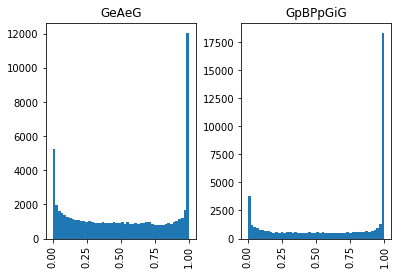

In [7]:
%matplotlib inline
dwpc_df.query("nnz > 0").hist(bins=50, column='p_value', by='metapath');

## Combine DWPC and pQTL information

In [8]:
snp_dwpc_df = (
    snp_df
    .merge(dwpc_df, left_on=['pqtl_entrez_id', 'locus_entrez_id'], right_on=['source_id', 'target_id'])
    .drop(columns=['source_id', 'target_id', 'source_name', 'target_name'])
)
snp_dwpc_df.head(2)

,snp,pqtl_gene,pqtl_entrez_id,neg_log10_p,gwas_source,locus_gene,locus_entrez_id,distance_to_snp,source_degree,target_degree,path_count,dwpc,n,nnz,n_perms,mean_nz,sd_nz,p_value,metapath
0,rs651007,SELE,6401,102.728,23300549,ABO,28,3217,64,2,1,0.365962,16671200,16015787,200,0.70011,0.585244,0.632176,GpBPpGiG
1,rs651007,SELE,6401,102.728,23300549,ABO,28,3217,56,0,0,0.000000,107197600,0,200,NaN,NaN,1.000000,GeAeG


In [9]:
snp_dwpc_df.to_csv('candidates.tsv', index=False, sep='\t')

## Potential candidates of interest

In [10]:
groups = snp_dwpc_df.groupby(['gwas_source', 'snp', 'pqtl_gene'])
groups = [df.sort_values('p_value') for i, df in groups]

In [11]:
groups[2]

,snp,pqtl_gene,pqtl_entrez_id,neg_log10_p,gwas_source,locus_gene,locus_entrez_id,distance_to_snp,source_degree,target_degree,path_count,dwpc,n,nnz,n_perms,mean_nz,sd_nz,p_value,metapath
128300,rs10127775,MAP2K4,6416,13.165,10.1101/086793,GALNT2,2590,102052,58,4,90,3.077606,14578000,14516202,200,0.992799,0.590786,0.005898,GpBPpGiG
128328,rs10127775,MAP2K4,6416,13.165,10.1101/086793,ABCB10,23456,601347,58,1,45,1.002571,36748400,31504598,200,0.401718,0.489000,0.088133,GpBPpGiG
128336,rs10127775,MAP2K4,6416,13.165,10.1101/086793,C1orf198,84886,677077,58,1,45,1.002571,36748400,31504598,200,0.401718,0.489000,0.088133,GpBPpGiG
128352,rs10127775,MAP2K4,6416,13.165,10.1101/086793,ARV1,64801,818939,58,1,45,1.002571,36748400,31504598,200,0.401718,0.489000,0.088133,GpBPpGiG
128344,rs10127775,MAP2K4,6416,13.165,10.1101/086793,TTC13,79573,746201,58,2,15,1.269866,23724400,22677352,200,0.672460,0.579313,0.129698,GpBPpGiG
128353,rs10127775,MAP2K4,6416,13.165,10.1101/086793,ARV1,64801,818939,52,40,36,1.681343,12762600,12762600,200,1.603165,0.105887,0.227055,GeAeG
128345,rs10127775,MAP2K4,6416,13.165,10.1101/086793,TTC13,79573,746201,52,40,37,1.667824,12762600,12762600,200,1.603165,0.105887,0.266128,GeAeG
128337,rs10127775,MAP2K4,6416,13.165,10.1101/086793,C1orf198,84886,677077,52,57,49,1.868927,8556200,8556200,200,1.804382,0.124716,0.296513,GeAeG
128317,rs10127775,MAP2K4,6416,13.165,10.1101/086793,TAF5L,27097,533995,52,38,35,1.622112,12236800,12236800,200,1.574246,0.104919,0.317808,GeAeG
128313,rs10127775,MAP2K4,6416,13.165,10.1101/086793,URB2,9816,499843,52,19,19,1.249957,15582800,15582800,200,1.207533,0.112278,0.342953,GeAeG


In [12]:
groups[7]

,snp,pqtl_gene,pqtl_entrez_id,neg_log10_p,gwas_source,locus_gene,locus_entrez_id,distance_to_snp,source_degree,target_degree,path_count,dwpc,n,nnz,n_perms,mean_nz,sd_nz,p_value,metapath
158871,rs10494745,HPX,3263,66.571,10.1101/086793,CFH,3075,170823,26,63,24,3.042011,6210000,6210000,200,1.397097,0.113697,0.000000,GeAeG
158865,rs10494745,HPX,3263,66.571,10.1101/086793,F13B,2165,120864,26,8,7,1.962293,23274000,23271949,200,0.777567,0.181986,0.000001,GeAeG
158863,rs10494745,HPX,3263,66.571,10.1101/086793,CFHR1,3078,86138,26,19,14,1.828663,17604000,17604000,200,1.061897,0.151818,0.000012,GeAeG
158870,rs10494745,HPX,3263,66.571,10.1101/086793,CFH,3075,170823,79,18,108,3.687287,1178000,1177800,200,2.007228,0.397697,0.000253,GpBPpGiG
158860,rs10494745,HPX,3263,66.571,10.1101/086793,CFHR5,81494,59229,79,1,23,4.141619,15394600,13574476,200,0.452063,0.511281,0.000365,GpBPpGiG
158866,rs10494745,HPX,3263,66.571,10.1101/086793,CFHR3,10878,122921,79,2,24,3.803143,9938600,9638663,200,0.761329,0.597103,0.001280,GpBPpGiG
158856,rs10494745,HPX,3263,66.571,10.1101/086793,CFHR4,10877,645,79,3,30,3.611719,7830600,7770566,200,0.964608,0.603812,0.001982,GpBPpGiG
158861,rs10494745,HPX,3263,66.571,10.1101/086793,CFHR5,81494,59229,26,4,4,1.214629,35424000,35105552,200,0.585058,0.192930,0.004308,GeAeG
158869,rs10494745,HPX,3263,66.571,10.1101/086793,ASPM,259266,165801,26,13,11,1.386351,18306000,18305992,200,0.935242,0.165381,0.007363,GeAeG
158862,rs10494745,HPX,3263,66.571,10.1101/086793,CFHR1,3078,86138,79,4,28,2.768193,6107000,6095144,200,1.121360,0.591223,0.014682,GpBPpGiG


In [13]:
groups[8]

,snp,pqtl_gene,pqtl_entrez_id,neg_log10_p,gwas_source,locus_gene,locus_entrez_id,distance_to_snp,source_degree,target_degree,path_count,dwpc,n,nnz,n_perms,mean_nz,sd_nz,p_value,metapath
113795,rs10737680,CFH,3075,35.89,10.1101/086793,F13B,2165,328866,63,8,8,1.588330,9913000,9913000,200,0.829301,0.119651,1.744131e-07,GeAeG
113790,rs10737680,CFH,3075,35.89,10.1101/086793,CFHR5,81494,267231,21,1,21,4.667195,116204400,86925262,200,0.273747,0.431237,1.036125e-04,GpBPpGiG
113770,rs10737680,CFH,3075,35.89,10.1101/086793,CFHR3,10878,64470,21,2,21,4.320710,75020400,65062638,200,0.449195,0.527825,3.667743e-04,GpBPpGiG
113782,rs10737680,CFH,3075,35.89,10.1101/086793,CFHR4,10877,139916,21,3,27,4.141113,59108400,55000247,200,0.558740,0.555346,5.307030e-04,GpBPpGiG
113779,rs10737680,CFH,3075,35.89,10.1101/086793,CFHR1,3078,109432,63,19,19,1.563467,7498000,7498000,200,1.222905,0.116307,3.220645e-03,GeAeG
113794,rs10737680,CFH,3075,35.89,10.1101/086793,F13B,2165,328866,21,2,3,2.218504,75020400,65062638,200,0.449195,0.527825,1.272660e-02,GpBPpGiG
113791,rs10737680,CFH,3075,35.89,10.1101/086793,CFHR5,81494,267231,63,4,4,0.872025,15088000,15087979,200,0.598196,0.124631,2.289278e-02,GeAeG
113778,rs10737680,CFH,3075,35.89,10.1101/086793,CFHR1,3078,109432,21,4,16,1.846759,46098000,44387506,200,0.647093,0.568289,4.176937e-02,GpBPpGiG
113799,rs10737680,CFH,3075,35.89,10.1101/086793,ASPM,259266,373803,63,13,13,1.137691,7797000,7797000,200,1.033490,0.115469,1.812262e-01,GeAeG
113787,rs10737680,CFH,3075,35.89,10.1101/086793,CFHR2,3080,233447,63,23,23,1.415769,6302000,6302000,200,1.325456,0.112639,2.082685e-01,GeAeG


## Cypher queries

Use at https://neo4j.het.io.

### GpBPpGiG

```cypher
MATCH path = (n0:Gene)-[:PARTICIPATES_GpBP]-(n1)-[:PARTICIPATES_GpBP]-(n2)-[:INTERACTS_GiG]-(n3:Gene)
WHERE n0.name = 'MAP2K4'
  AND n3.name = 'GALNT2'
AND n0 <> n2 AND n0 <> n3 AND n2 <> n3
WITH [
  size((n0)-[:PARTICIPATES_GpBP]-()),
  size(()-[:PARTICIPATES_GpBP]-(n1)),
  size((n1)-[:PARTICIPATES_GpBP]-()),
  size(()-[:PARTICIPATES_GpBP]-(n2)),
  size((n2)-[:INTERACTS_GiG]-()),
  size(()-[:INTERACTS_GiG]-(n3))
] AS degrees, path
RETURN
  path,
  substring(reduce(string = '', node IN nodes(path) | string + '—' + node.name), 1) AS nodes,
  reduce(pdp = 1.0, d in degrees | pdp * d ^ -0.5) AS pdp
ORDER BY pdp DESC
LIMIT 10
```

### GeAeG

```cypher
MATCH path = (n0:Gene)-[:EXPRESSES_AeG]-(n1)-[:EXPRESSES_AeG]-(n2:Gene)
USING JOIN ON n1
WHERE n0.name = 'MAP2K4'
  AND n2.name = 'GALNT2'
  AND n0 <> n2
WITH [
  size((n0)-[:EXPRESSES_AeG]-()),
  size(()-[:EXPRESSES_AeG]-(n1)),
  size((n1)-[:EXPRESSES_AeG]-()),
  size(()-[:EXPRESSES_AeG]-(n2))
] AS degrees, path
RETURN
  path,
  substring(reduce(string = '', node IN nodes(path) | string + '—' + node.name), 1) AS nodes,
  reduce(pdp = 1.0, d in degrees | pdp * d ^ -0.5) AS pdp
ORDER BY pdp DESC
LIMIT 10
```

### Method

To create DWPC queries, you can use the following method:

```python
metapath = hetmat.metagraph.get_metapath('GpBPpGiG')
query = hetio.neo4j.construct_dwpc_query(metapath)
print(query)
```